# Import datasets

In [ ]:
import os

images_classes_path = '/content/CoinDetector/train'

images_classes_list = os.listdir(images_classes_path)

num_classes = len(images_classes_list)
print("total {} classes".format(num_classes))

total 6 classes


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime
!rm -rf ./logs/ 

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import matplotlib.image as mpimg
import numpy as np

# Preprocessing

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image      
import random

We splitted the dataset in the following manner:
* 70% data was used for model training procedure.
* 30% data for model evaluation.

In [ ]:
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.4,
)

train_generator = datagen.flow_from_directory(
        images_classes_path,
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical',
        shuffle=True,
        subset="training"
)

val_generator = datagen.flow_from_directory(
        images_classes_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False,
        subset="validation"
)

test_dir = '/content/CoinDetector/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        shuffle=False,
        batch_size=1,
        class_mode='categorical')

filenames = test_generator.filenames
nb_samples = len(filenames)

Found 1756 images belonging to 6 classes.
Found 1167 images belonging to 6 classes.
Found 120 images belonging to 6 classes.


# Model configuration

In [ ]:
import keras
from keras.layers import Input
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam 

from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

## Using an existing model from Keras

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
base_model = VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))
base_model.summary()

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

### Remove the last 4 layers

In [ ]:
for i in range(4):
  base_model.layers.pop()
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#Fine-tuning the model

In [ ]:
x = base_model.output
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate = .5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.inputs, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

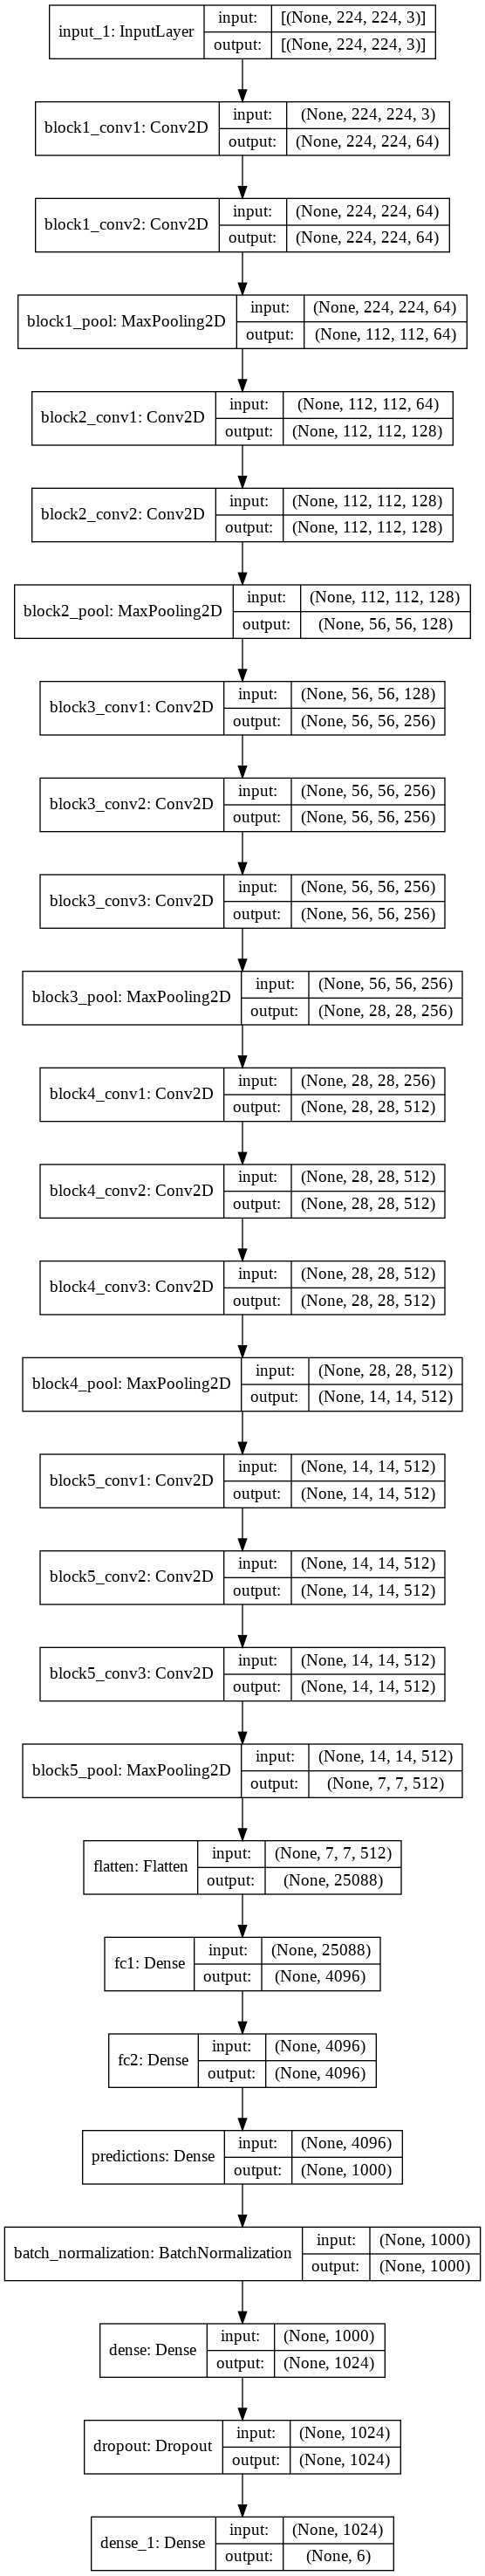

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

We will freeze and only train the last 7 layers.

> This technique is called **Transfer Learning**.



In [ ]:
for layer in model.layers[:]:
    layer.trainable = True 
    
for layer in model.layers[:-7]:
    layer.trainable = False

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 flatten False
20 fc1 True
21 fc2 True
22 predictions True
23 batch_normalization True
24 dense True
25 dropout True
26 dense_1 True


For this specification, Adam optimizer is the most suitable (with learning rate = 0.0001)

In [ ]:
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train the model

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

While the model was training, we only saved those with the highest validation accuracy.

In [ ]:
ocheckpoint = ModelCheckpoint('model.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

my_callbacks = [checkpoint, tensorboard_callback]

In [ ]:
model.fit_generator(generator=train_generator, 
                              steps_per_epoch=len(train_generator), 
                              validation_data=val_generator, 
                              validation_steps=len(val_generator),
                              epochs=1,
                              callbacks=my_callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


28/28 [==============================] - 87s 2s/step - loss: 1.5957 - accuracy: 0.4434 - val_loss: 1.7290 - val_accuracy: 0.8835


Now, unfreeze all layers!

In [ ]:
for layer in model.layers[:]:
    layer.trainable = True

In [ ]:
params = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=val_generator, 
                                validation_steps=len(val_generator),
                                epochs=3,
                                callbacks=my_callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
28/28 [==============================] - 33s 1s/step - loss: 0.7277 - accuracy: 0.9134 - val_loss: 1.6127 - val_accuracy: 0.9357
Epoch 2/3
28/28 [==============================] - 32s 1s/step - loss: 0.2334 - accuracy: 0.9846 - val_loss: 1.4639 - val_accuracy: 0.9477
Epoch 3/3
28/28 [==============================] - 32s 1s/step - loss: 0.0921 - accuracy: 0.9909 - val_loss: 1.3699 - val_accuracy: 0.9280


# Test the model on some real images

In [ ]:
def predict_images(path):
    img = plt.imread(path)
    plt.imshow(img)


    image = Image.open(path)
    image = image.convert('RGB')
    image = image.resize((224, 224))

    probabilities = model.predict(np.expand_dims(image, axis=0))
    type_list = tuple(zip(val_generator.class_indices.values(), val_generator.class_indices.keys()))

    for i in probabilities.argsort()[0][-6:][::-1]: 
         print(probabilities[0][i], "  :  " , type_list[i][1])

predict_images('/content/test3.jpg')

FileNotFoundError: ignored

In [ ]:
import cv2
import numpy as np
from matplotlib import cm


In [ ]:
print(cv2.__version__)

4.1.2


In [ ]:
def predict_images(img):
#     img = mpimg.imread(path)
#     plt.imshow(img)


#     image = Image.open(path)
    image = img.convert('RGB')
    image = image.resize((224, 224))

    probabilities = model.predict(np.expand_dims(image, axis=0))
    type_list = tuple(zip(val_generator.class_indices.values(), val_generator.class_indices.keys()))

    for i in probabilities.argsort()[0][-6:][::-1]: 
        return probabilities[0][i], type_list[i][1]
#         print(probabilities[0][i], "  :  " , type_list[i][1])
            
# img_dir = 'C:\\Users\\khanh\\Downloads\\IMG_4193_1.jpg'

# img = Image.open(img_dir)
# print(predict_images(img))

In [ ]:
print